In [1]:
# Cell 1: Package installation (optional)
# Uncomment ONLY if running for the first time.
!pip install --upgrade pip setuptools
!pip install aif360
#pandas scikit-learn matplotlib seaborn

In [5]:
#Cell 2: Imports
import pandas as pd # For data manipulation
import numpy as np # For numeric operations
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # Additional visualization
from sklearn.linear_model import LogisticRegression # Simple classifier
from sklearn.metrics import confusion_matrix # For confusion matrices


# AIF360 imports for fairness auditing
from aif360.datasets import BinaryLabelDataset # AIF360 dataset format
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing # Pre-processing bias mitigation

In [6]:
# ------------------------
# Cell 3: Load COMPAS dataset
# ------------------------
# Load the raw dataset directly from ProPublica’s GitHub
DATA_URL = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
print('Loading dataset from:', DATA_URL)
df = pd.read_csv(DATA_URL)
print('Rows, cols:', df.shape)


# Show columns and a sample of important variables
print(df.columns.tolist())
print(df[['race','sex','age','score_text','two_year_recid']].head())

Loading dataset from: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Rows, cols: (7214, 53)
['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event', 'two_year_recid']
               race   sex  a

In [7]:
# ------------------------
# Cell 4: Basic preprocessing
# ------------------------
# Keep only African-American and Caucasian defendants for comparison
# (this matches the common ProPublica fairness setup)
df = df[df['race'].isin(['African-American','Caucasian'])].copy()


# Remove rows missing key fields
df = df[df['two_year_recid'].notna() & df['score_text'].notna()]


# Create binary label: 1 = reoffended within 2 years, 0 = no
df['label'] = df['two_year_recid'].astype(int)


# Convert COMPAS risk categories to predicted label
# Medium/High = model predicts “will reoffend” → 1
# Low = “will not reoffend” → 0
df['predicted'] = df['score_text'].isin(['Medium','High']).astype(int)


# Keep only relevant columns for auditing
cols = ['id','race','sex','age','priors_count','label','predicted']
print('Filtered rows, cols:', df.shape)
print(df[cols].head())

Filtered rows, cols: (6150, 55)
   id              race     sex  age  priors_count  label  predicted
1   3  African-American    Male   34             0      1          0
2   4  African-American    Male   24             4      1          0
3   5  African-American    Male   23             1      0          1
6   8         Caucasian    Male   41            14      1          1
8  10         Caucasian  Female   39             0      0          0


In [13]:
# ------------------------
# Cell 5: Build AIF360 dataset objects
# ------------------------
# AIF360 requires a specific dataset wrapper.
# Ensure the DataFrame contains no NA values and only relevant columns.
aif_df = df[cols].dropna()

# Convert categorical features ('race', 'sex') to numerical using one-hot encoding
aif_df = pd.get_dummies(aif_df, columns=['race', 'sex'], drop_first=True)

bld = BinaryLabelDataset(df=aif_df,
label_names=['label'],
protected_attribute_names=['race_Caucasian'])


# Create a second dataset for predicted labels by replacing the label column with predictions
pred_aif_df = aif_df.copy()
pred_aif_df['label'] = pred_aif_df['predicted']


pred_bld = BinaryLabelDataset(df=pred_aif_df,
label_names=['label'],
protected_attribute_names=['race_Caucasian'])

In [15]:
# ------------------------
# Cell 6: Compute fairness metrics
# ------------------------
# BinaryLabelDatasetMetric: for distribution-based metrics
metric_true = BinaryLabelDatasetMetric(bld,
privileged_groups=[{'race_Caucasian': True}],
unprivileged_groups=[{'race_Caucasian': False}])


metric_pred = BinaryLabelDatasetMetric(pred_bld,
privileged_groups=[{'race_Caucasian': True}],
unprivileged_groups=[{'race_Caucasian': False}])


# ClassificationMetric: computes FPR, FNR, accuracy, etc.
cm = ClassificationMetric(bld, pred_bld,
unprivileged_groups=[{'race_Caucasian': False}],
privileged_groups=[{'race_Caucasian': True}])


# Extract key fairness metrics
fpr_priv = cm.false_positive_rate(privileged=True)
fpr_unpriv = cm.false_positive_rate(privileged=False)
fnr_priv = cm.false_negative_rate(privileged=True)
fnr_unpriv = cm.false_negative_rate(privileged=False)


# Disparate impact < 0.8 indicates likely discrimination
disparate_impact = metric_pred.disparate_impact()


print('FPR (Caucasian):', fpr_priv)
print('FPR (African-American):', fpr_unpriv)
print('FNR (Caucasian):', fnr_priv)
print('FNR (African-American):', fnr_unpriv)
print('Disparate Impact:', disparate_impact)

FPR (Caucasian): 0.23454301075268819
FPR (African-American): 0.44846796657381616
FNR (Caucasian): 0.4772256728778468
FNR (African-American): 0.27985270910047344
Disparate Impact: 1.6902240031631133


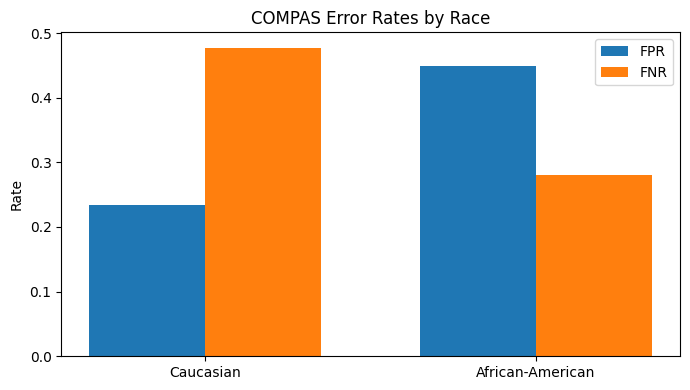

Caucasian: TP=505, FP=349, TN=1139, FN=461
African-American: TP=1369, FP=805, TN=990, FN=532


In [17]:
# ------------------------
# Cell 7: Visualization
# ------------------------
# Compare group error rates in a bar chart
groups = ['Caucasian','African-American']
vals_fpr = [fpr_priv, fpr_unpriv]
vals_fnr = [fnr_priv, fnr_unpriv]

x = np.arange(len(groups))
width = 0.35
fig, ax = plt.subplots(figsize=(7,4))


# Plot FPR and FNR
ax.bar(x - width/2, vals_fpr, width, label='FPR')
ax.bar(x + width/2, vals_fnr, width, label='FNR')


ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.set_ylabel('Rate')
ax.set_title('COMPAS Error Rates by Race')
ax.legend()
plt.tight_layout()
plt.show()


# Print confusion matrices per race
for race in groups:
    sub = df[df['race']==race]
    tn, fp, fn, tp = confusion_matrix(sub['label'], sub['predicted']).ravel()
    print(f"{race}: TP={tp}, FP={fp}, TN={tn}, FN={fn}")

In [21]:
# ------------------------
# Cell 8: Bias mitigation via Reweighing
# ------------------------
# Select simple features for a demo model
feat_df = df[['priors_count','age','race','label']].dropna().copy()

# Convert 'race' to numerical using one-hot encoding for AIF360
feat_df_encoded = pd.get_dummies(feat_df, columns=['race'], drop_first=False) # Keep both for reweighing
X = feat_df_encoded[['priors_count','age', 'race_African-American', 'race_Caucasian']].values
y = feat_df_encoded['label'].values


# Convert to AIF360 dataset for reweighing
dataset_orig = BinaryLabelDataset(df=feat_df_encoded,
label_names=['label'],
protected_attribute_names=['race_African-American', 'race_Caucasian'])


# Apply Reweighing algorithm
rw = Reweighing(unprivileged_groups=[{'race_African-American': 1}],
privileged_groups=[{'race_Caucasian': 1}])


dataset_transf = rw.fit_transform(dataset_orig)


# Train logistic regression with sample weights from reweighing
weights = dataset_transf.instance_weights
clf = LogisticRegression(max_iter=1000)
clf.fit(X, y, sample_weight=weights)


# Predict on the same data (demo)
y_pred = clf.predict(X)


# Wrap predictions into AIF360 dataset
pred_feat_df = feat_df_encoded.copy()
pred_feat_df['label'] = y_pred
pred_dataset = BinaryLabelDataset(df=pred_feat_df,
label_names=['label'],
protected_attribute_names=['race_African-American', 'race_Caucasian'])


cm_after = ClassificationMetric(dataset_orig, pred_dataset,
unprivileged_groups=[{'race_African-American': 1}],
privileged_groups=[{'race_Caucasian': 1}])


print('\nAfter Reweighing:')
print('FPR (Caucasian):', cm_after.false_positive_rate(privileged=True))
print('FPR (African-American):', cm_after.false_positive_rate(privileged=False))
print('Disparate Impact:',
BinaryLabelDatasetMetric(pred_dataset,
privileged_groups=[{'race_Caucasian': 1}],
unprivileged_groups=[{'race_African-American': 1}]).disparate_impact())


After Reweighing:
FPR (Caucasian): 0.32661290322580644
FPR (African-American): 0.1883008356545961
Disparate Impact: 0.7901633712729219


In [22]:
# ------------------------
# Cell 9: Save the visualization
# ------------------------
fig.savefig('compas_error_rates_by_race.png', bbox_inches='tight')


print('Notebook complete: data loaded, bias metrics computed, visualized, and mitigation applied.')

Notebook complete: data loaded, bias metrics computed, visualized, and mitigation applied.
